<a href="https://colab.research.google.com/github/brunoBenedicto/Estudos_Python/blob/main/dimensionamento_paineis_fotovoltaicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dimensionamento de paineis fotovoltaicos

## Introdução


### 1
Referencia – LABREN/CCST/INPE <http://
labren.ccst.inpe.br> em parceria com a UFSC (Martins et al.,
2007) (Labren)


### 2
A irradiância solar (W/m2) que incide em uma superfície é
composta por suas componentes direta e difusa. A irradiância
solar direta apresenta direção de incidência na linha imaginária
entre a superfície e o Sol e representa a parcela que não sofreu
os processos radiativos de absorção e espalhamento que
ocorrem na atmosfera. A componente difusa engloba a
radiação proveniente de todas as demais direções que são
decorrentes dos processos de espalhamento pelos gases e
particulados presentes na atmosfera. A terminologia adotada
por este Atlas é a seguinte:
Irradiância extraterrestre (G0
): é a taxa de energia
incidente por unidade de área em um plano horizontal
imaginário situado no topo da atmosfera. É também conhecido
como irradiância no topo da atmosfera ou GTOA
.
Irradiância direta normal (Gn
): também conhecida como
DNI, é a taxa de energia por unidade de área proveniente
diretamente do Sol que incide perpendicularmente à superfície.
Irradiância difusa horizontal (Gdif
): é a taxa de energia
incidente sobre uma superfície horizontal por unidade de área,
decorrente do espalhamento do feixe solar direto pelos
constituintes atmosféricos (moléculas, material particulado,
nuvens, etc.).
Irradiância direta horizontal (Gdir
): é a taxa de energia por
unidade de área do feixe solar direto numa superfície
horizontal. Pode ser determinada como o produto entre a
irradiância direta normal (DNI) e o cosseno do ângulo zenital
solar.
Irradiância global horizontal (G): é a taxa de energia total
por unidade de área incidente numa superfície horizontal. A
irradiância global é dada pela soma G = Gdif + Gdir ou G = Gdif
+ Gn
.cos(θz) onde θz é o ângulo zenital.
Irradiância no plano inclinado (Gi
): é a taxa de energia
total por unidade de área incidente sobre um plano inclinado na
latitude do local em relação à superfície da Terra.
A Figura 13 ilustra a irradiância assim que atinge a
atmosfera e seu espalhamento.

(Labren)

## Base de Dados

### Características gerais

A base de dados está disponível em diferentes abrangências: para TODO O BRASIL, para CADA ESTADO separadamente, para as SEDES DE MUNICÍPIOS e como CONSULTA A LOCAIS ESPECÍFICOS.
A base é composta de 72272 registros contendo as médias anuais e mensais do total diário da irradiação Global Horizontal, Difusa, Direta Normal, no Plano Inclinado e PAR em Wh/m2.dia.
Resolução espacial de 0,1° x 0,1° (aproximadamente 10 km x 10 km).
Longitude e latitude definem o centroide das entidades, ou células, de 0,1° x 0,1°.
Conjunto de caracteres Unicode UTF-8. (Labren)

### carregar dados no Google Colab

**1** Baixar o arquivo plano inclinado do labren no seu dispositivo. segue o link: http://labren.ccst.inpe.br/atlas_2017.html#mod
baixar arquivos formato completo CSV da sessao
**Download da base de dados - BRASIL COMPLETO ou todas as SEDES DE MUNICÍPIOS**

**2** No google colab
Nos icones do canto esquerdo, clicar no icone de uma pasta **(arquivos)**,depois no icone **Upload** e selecionar o arquivo do seu dispositivo, o arquivo com **os dados ficará abaixo da pasta sample_data**. com o botao direito selecionar copiar caminho e depois colar no codigo onde tem a atribuicao da variavel "caminho_do_arquivo" na sessao **Tratamento de dados**.

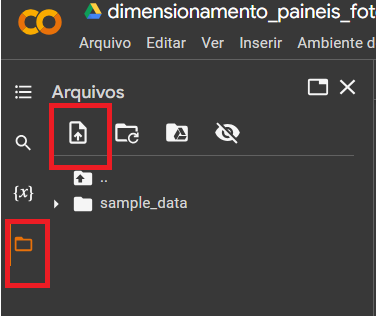




### Tratamento de dados


Sendo o intervalo das coordenadoras de 0.1°, trunca-se os valores das coordenadoras para o formato x.x°. com isso ao consultar qualquer coordenada, basta arredonda-la até a primeira casa decimal para encontrar a coordenada mais próxima na base de dados

In [ ]:
import pandas as pd # biblioteca para acessar arquivos tabulares(no caso, CSV), o pd serve como apelido do pandas

caminho_do_arquivo = '/content/tilted_latitude_means.csv'
plano_inclinado = pd.read_csv(caminho_do_arquivo, sep=';') # armazena os dados do arquivo que estão separados por ponto e virgula

# Truncar os valores das colunas LAT e LONpara 1 dígito após a casa decimal
plano_inclinado['LAT'] = plano_inclinado['LAT'].apply(lambda x: format(x, '.2f')).astype(float)
plano_inclinado['LON'] = plano_inclinado['LON'].apply(lambda x: format(x, '.1f')).astype(float)

## Obtenção das Coordenadas

### API OpenStreetMap

A API OpenStreetMap também permite a obtenção de informações geográficas específicas por meio do uso de coordenadas. Os desenvolvedores podem realizar consultas para obter dados detalhados sobre elementos do mapa com base em suas coordenadas geográficas, como latitude e longitude. Isso possibilita a criação de funcionalidades como geocodificação reversa, onde é possível obter informações sobre um local com base em suas coordenadas. As coordenadas são uma parte essencial da API OpenStreetMap, pois permitem uma precisão e especificidade no acesso aos dados geográficos.

### Consultar coordenadas pelo endereço

A função abaixo recebe uma seringa contendo o endereço, e faz uma requisição a API que retorna as informações sobre o endereço, incluindo as coordenadas. A função devolve a latitude e longitude.

In [ ]:
import requests # biblioteca para consultar APIs

# esta funçao usa o endereco fornecido para para obter as coordenadas atraves da API OpenStreetMap
def obter_coordenadas(endereco):
    url = "https://nominatim.openstreetmap.org/search?q={}&format=json".format(endereco)
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        if data:
            latitude = float(data[0]['lat'])
            longitude = float(data[0]['lon'])
            return latitude, longitude
        else:
            print('Nenhum resultado encontrado para o endereço fornecido.')
    else:
        print('Erro ao fazer a solicitação à API:', response.status_code)


## Calcular Painéis

Para determinar a quantidade de painéis é necessário saber a Irradiação média diária do local a ser instalado os painéis fotovoltaicos, o Consumo médio diário em watts, o tipo de fornecimento de energia elétrica e a potência dos painéis.

### Consultar Irradiação

A função recebe dois parâmetros (latitude e longitude), faz a consulta no arquivo "plano inclinado" e devolve uma linha com as informações de média diária de cada mês do ano.

In [ ]:
def consultar_irradiacao(latitude, longitude):
  linha = plano_inclinado[(plano_inclinado['LAT'] == round(float(latitude), 1)) & (plano_inclinado['LON'] == round(float(longitude), 1))]
  return linha

Para evitar que os painéis fiquem ociosos em determinadas épocas do ano, usa-se o valor da menor média diária.

A função abaixo recebe uma linha com os meses e suas médias diárias de irradiação, e devolve o mês com menor valor e a irradiação correspondente.

In [ ]:
def obter_mes_menor_irradiacao(linha):
    meses = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    irradiacoes = [linha[mes].values[0] for mes in meses]
    menor_irradiacao = min(irradiacoes)
    indice_menor_irradiacao = irradiacoes.index(menor_irradiacao)
    mes_menor_irradiacao = meses[indice_menor_irradiacao]
    return mes_menor_irradiacao, menor_irradiacao

### Definir quantidade de painéis

A função calcular_paineis recebe como parâmetro o consumo medio mensal(kw/h), o tipo de fornecimento(monofásico, bifásico ou trifásico), a potência do painel (watts) e a irradiação média diária (watts)

In [ ]:

import math
#calcular a quantidade de paineis


def calcular_paineis(cosumo_medio, tipo_de_fornecimento, potencia_do_painel, menor_irradicao):
    _desconto = calcularDesconto(tipo_de_fornecimento)
    consumo_medio_mensal = cosumo_medio - _desconto
    consumo_medio_diario = consumo_medio_mensal / 30
    quantidade_de_paineis = math.ceil((((consumo_medio_diario) / (menor_irradicao / 1000)) * 1000) / potencia_do_painel)
    return quantidade_de_paineis

A função auxiliar calcularDeconto recebe o tipo de fornecimento e devolve o desconto referente em watts

In [ ]:
def calcularDesconto(tipo_de_fornecimento):
    if tipo_de_fornecimento == 'monofasico':
        desconto = 30
    elif tipo_de_fornecimento == 'bifasico':
        desconto = 50
    elif tipo_de_fornecimento == 'trifasico':
        desconto = 100
    else:
        desconto = 0  # Valor padrão caso o tipo de fornecimento não seja reconhecido

    return desconto

# Exemplo de uso

In [ ]:

endereco = "parnamirim, rio grande do norte , brasil" # preencher endereço entre as aspas
consumoMedioMensal = 500 #inserir consumo medio em kw/h
potencia = 280  # inserir potência do painel em watts

#chamada das funções e atribuicao dos retornos às variaveis
coordenadas = obter_coordenadas(endereco)
latitude, longitude = coordenadas
print(coordenadas)
irradiacao = consultar_irradiacao(latitude, longitude)
mes, minimo = obter_mes_menor_irradiacao(irradiacao)
qtd_paineis = calcular_paineis(consumoMedioMensal, 'monofasico', potencia, minimo)

#Resultado

print("Coordenadas de", endereco)
print(coordenadas)
print("o mes com menor irradiacao é", mes)
print(" com irradiacao media diaria de ",  minimo, "kw/h por m²")
print("para um consumo mensal de ",consumoMedioMensal,"kw/h, é preciso de ", qtd_paineis, "paineis de ",potencia,"w")

(-5.9153334, -35.2679913)
Coordenadas de parnamirim, rio grande do norte , brasil
(-5.9153334, -35.2679913)
o mes com menor irradiacao é JUN
 com irradiacao media diaria de  4834 kw/h por m²
para um consumo mensal de  500 kw/h, é preciso de  12 paineis de  280 w
